# Retrievals with Dataset Offsets

When fitting multiple datasets observed at different times, or with different instruments, differences in the analyses (e.g. different assumed orbital properties) or astrophysical properties (e.g. stellar variability) can imprint offsets between datasets.

This tutorial demonstrates how to fit free offsets between datasets with POSEIDON. 

Assuming you have completed the previous [\"Atmospheric Retrievals with POSEIDON\"](retrieval_basic.html) tutorial, let's proceed to explore this common systematic in the context of our WASP-999b transmission spectrum.

First, we load the system properties.

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J

#***** Define stellar properties *****#

R_s = 1.155*R_Sun     # Stellar radius (m)
T_s = 6071.0          # Stellar effective temperature (K)
Met_s = 0.0           # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.38        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-999b'  # Planet name used for plots, output files etc.

R_p = 1.359*R_J     # Planetary radius (m)
g_p = 9.186         # Gravitational field of planet (m/s^2)
T_eq = 1400.0       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

Load the Hubble Space Telescope WFC3 data for WASP-999b.

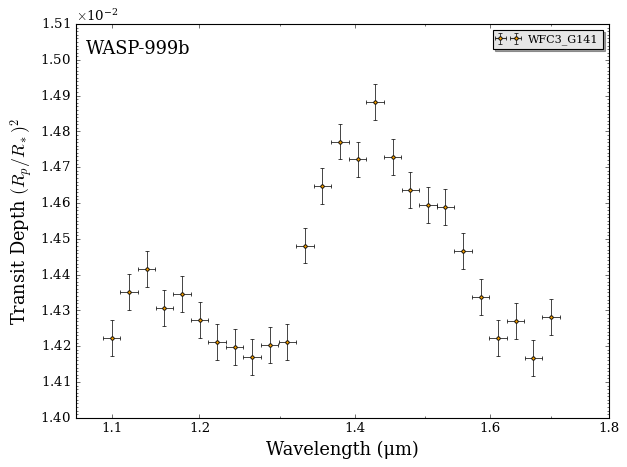

In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

#***** Model wavelength grid *****#

wl_min = 0.4      # Minimum wavelength (um)
wl_max = 1.8      # Maximum wavelength (um)
R = 4000          # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Specify data location and instruments  *****#

data_dir = '../../../POSEIDON/reference_data/observations/WASP-999b'  # Special directory for this tutorial
datasets = ['WASP-999b_WFC3_G141.dat']  # Found in reference_data/observations
instruments = ['WFC3_G141']             # Instruments corresponding to the data

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet_name)

To simulate an instrumental offset, let's add a constant 500 parts-per-million to the transit depth for this dataset and write a modified data file.

In [3]:
import numpy as np

ydata_offset = data['ydata'] + 500e-6    # We'll use a 500 ppm offset to the transit depth

out_name = data_dir + '/WASP-999b_WFC3_G141_OFFSET.dat'   # Name of new WFC3 data file

# Write output file
out_data = np.column_stack((data['wl_data'], data['half_bin'], ydata_offset, data['err_data']))
out_fmt = ['%.6f', '%.6f', '%.6e', '%.6e']
np.savetxt(out_name, out_data, delimiter = ' ', fmt = out_fmt)

Let's see what the full transmission spectrum of WASP-999b looks like with the offset.

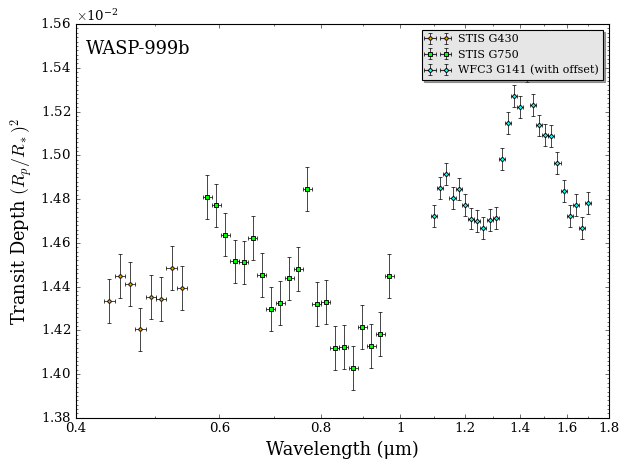

In [4]:
# Specify the STIS and new WFC3 Hubble data                
datasets = ['WASP-999b_STIS_G430.dat', 
            'WASP-999b_STIS_G750.dat', 
            'WASP-999b_WFC3_G141_OFFSET.dat']  
instruments = ['STIS_G430', 'STIS_G750', 'WFC3_G141']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet_name, 
                     data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141 (with offset)'])

Oh the horror, what a dreadful systematic! 😮

So should you be faced with the nightmare scenario of an *a priori* unknown offset between one or more datasets, what can you do about it?

## Retrievals with a Free Offset

We'll first define a model with a single free offset for WFC3 G141, which should essentially recognise and undo the 500 ppm offset we applied above.

In [5]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Retrieval_with_single_offset_wfc3'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']          # H2 + He comprises the bulk atmosphere
param_species = ['Na', 'K', 'H2O']

# Create the model object
model_offset_wfc3 = define_model(model_name, bulk_species, param_species, 
                                 PT_profile = 'isotherm', cloud_model = 'cloud-free',
                                 offsets_applied = 'single_dataset',   # One free offset
                                 )

# Check the free parameters defining this model
print("Free parameters: " + str(model_offset_wfc3['param_names']))

Free parameters: ['R_p_ref' 'T' 'log_Na' 'log_K' 'log_H2O' 'delta_rel']


The free parameter controlling the offset is called $\delta_{\rm{rel}}$ in units of parts-per-million.

Now we need to tell POSEIDON which dataset the offset should be applied to during the retrieval. You do this when loading the data by flagging the dataset that will have the free offset applied via the `offset_datasets` variable. Let's do that just for WFC3 G141.

In [6]:
#***** Specify data location and instruments  *****#

# Specify the STIS and new WFC3 Hubble data
datasets = ['WASP-999b_STIS_G430.dat', 
            'WASP-999b_STIS_G750.dat', 
            'WASP-999b_WFC3_G141_OFFSET.dat']  
instruments = ['STIS_G430', 'STIS_G750', 'WFC3_G141']

# Load dataset, pre-load instrument PSF and transmission function
data_offset_wfc3 = load_data(data_dir, datasets, instruments, wl, 
                             offset_datasets = ['WASP-999b_WFC3_G141_OFFSET.dat'])  # The key line

Now we need to specify the priors. For the atmospheric properties we'll use the same settings as the previous tutorial. For the offset, sometimes you may want to use a Gaussian prior centred on zero (e.g. if you have a reasonable expectation that large offsets are not very likely). But for simplicity, we'll just use here a uniform prior from -1000 to +1000 ppm.

In [7]:
from POSEIDON.core import set_priors

#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_H2O'] = 'uniform'
prior_types['delta_rel'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 1600]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_H2O'] = [-12, -1]
prior_ranges['delta_rel'] = [-1000, 1000]   # Offset units are in parts per million

# Create prior object for retrieval
priors = set_priors(planet, star, model_offset_wfc3, data_offset_wfc3, 
                    prior_types, prior_ranges)

As usual, load the cross sections and run the retrieval.

In [8]:
from POSEIDON.core import read_opacities
from POSEIDON.retrieval import run_retrieval

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 400     # Same as prior range for T
T_fine_max = 1600    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Pre-interpolate the opacities
opac = read_opacities(model_offset_wfc3, wl, opacity_treatment, T_fine, log_P_fine)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 10.0   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model_offset_wfc3, opac, data_offset_wfc3, priors, 
              wl, P, P_ref, R = R, spectrum_type = 'transmission', 
              sampling_algorithm = 'MultiNest', N_live = 400, verbose = False)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Na done
K done
H2O done
Opacity pre-interpolation complete.
POSEIDON now running 'Retrieval_with_single_offset_wfc3'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
POSEIDON retrieval finished in 0.17 hours
 ln(ev)=   431.64153895399710      +/-  0.20246530256370082     
 Total Likelihood Evaluations:        24802
 Sampling finished. Exiting MultiNest
Now generating 1000 sampled spectra and P-T profiles from the posterior distribution...
This process will take approximately 0.43 minutes
All done! Output files can be found in ./POSEIDON_output/WASP-999b/retrievals/results/


### Plot Retrieval Results

Corner plot time! Let's also overplot the true parameter values I used to make the data.

Generating corner plot ...


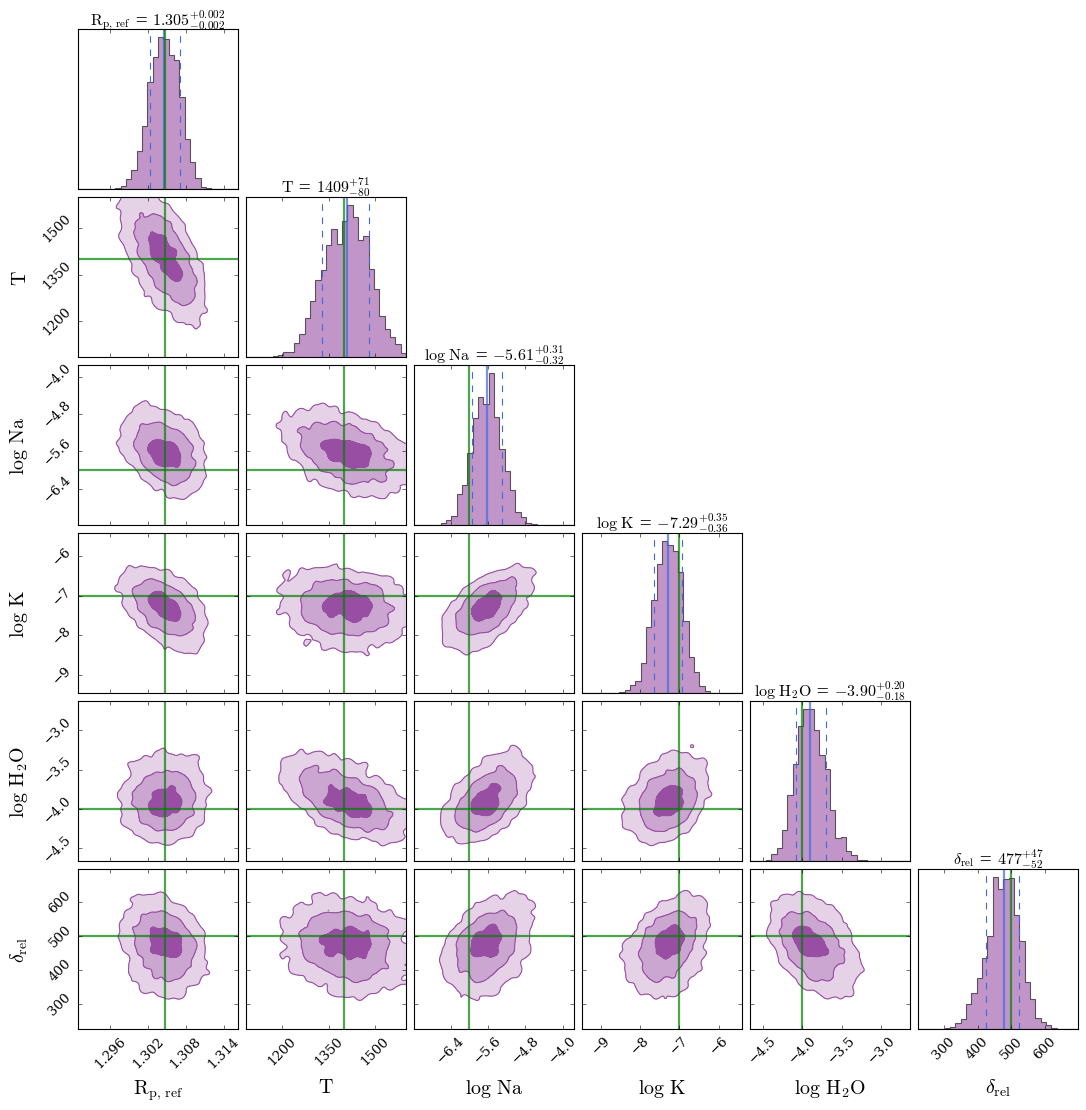

In [9]:
from POSEIDON.corner import generate_cornerplot

#***** Make corner plot *****#

fig_corner = generate_cornerplot(planet, model_offset_wfc3, 
                                 true_vals = [0.96*(R_p/R_J), 1400, 
                                              -6.0, -7.0, -4.0, 500])   # The last parameter is the offset

We see that the offset is correctly identified within 1σ.

Now let's plot the retrieved spectrum.

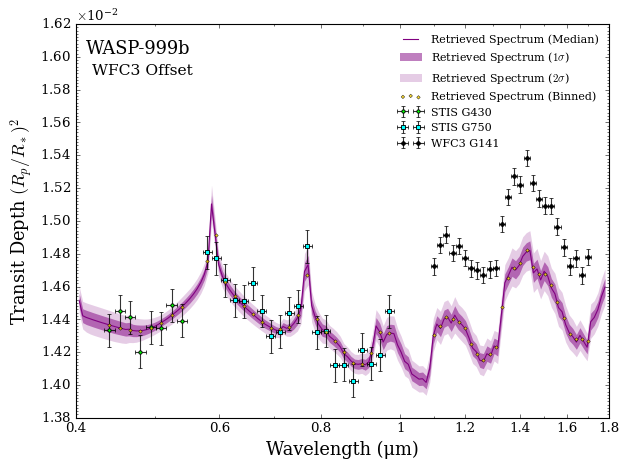

In [10]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved

#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data_offset_wfc3, R_to_bin = 100,
                                  plt_label = 'WFC3 Offset',
                                  data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141'],
                                  data_colour_list = ['lime', 'cyan', 'black'],
                                  )

By default, the data is shown without the retrieved offset.

We can correct for the offset by providing two additional optional arguments: `add_retrieved_offsets = True` and the `model` object. The plotting script will then access the retrieval output files to find the best-fitting retrieved offset and counteract it for visual purposes.

Applied 476.86 ppm offset to offset_datasets


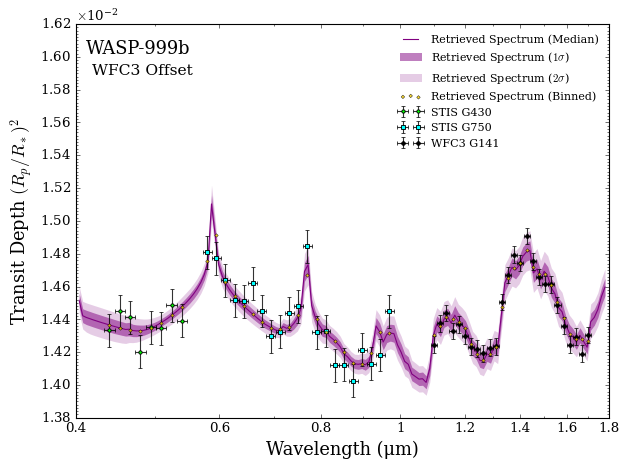

In [11]:
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data_offset_wfc3, R_to_bin = 100,
                                  plt_label = 'WFC3 Offset',
                                  data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141'],
                                  data_colour_list = ['lime', 'cyan', 'black'],
                                  model = model_offset_wfc3, add_retrieved_offsets = True,
                                  )

## Grouped Offset

Sometimes you may need to group more than one dataset together and apply the same offset to all datasets within the group. To demonstrate this, let's now group the two STIS datasets together with a free offset and instead assume WFC G141 has the correct baseline transit depth.

The model configuration is identical in this case to the one above.

In [12]:
model_name = 'Retrieval_with_single_offset_stis'

bulk_species = ['H2', 'He']
param_species = ['Na', 'K', 'H2O']

# Create the model object
model_offset_stis = define_model(model_name, bulk_species, param_species, 
                                 PT_profile = 'isotherm', cloud_model = 'cloud-free',
                                 offsets_applied = 'single_dataset',
                                 )

# Check the free parameters defining this model
print("Free parameters: " + str(model_offset_stis['param_names']))

Free parameters: ['R_p_ref' 'T' 'log_Na' 'log_K' 'log_H2O' 'delta_rel']


But we now need to group together the STIS datasets via the `offset_1_datasets` list.

In [13]:
data_offset_stis = load_data(data_dir, datasets, instruments, wl, 
                             offset_1_datasets = ['WASP-999b_STIS_G430.dat',
                                                  'WASP-999b_STIS_G750.dat'])

The priors and retrieval settings are the same as above (but note the updated `model` and `data` objects).

In [14]:
#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_H2O'] = 'uniform'
prior_types['delta_rel'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 1600]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_H2O'] = [-12, -1]
prior_ranges['delta_rel'] = [-1000, 1000]   # Offset units are in parts per million

# Set priors
priors = set_priors(planet, star, model_offset_stis, data_offset_stis, 
                    prior_types, prior_ranges)

#**** Run atmospheric retrieval *****#

run_retrieval(planet, star, model_offset_stis, opac, data_offset_stis, priors, 
              wl, P, P_ref, R = R, spectrum_type = 'transmission', 
              sampling_algorithm = 'MultiNest', N_live = 400, verbose = False)

POSEIDON now running 'Retrieval_with_single_offset_stis'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
POSEIDON retrieval finished in 0.17 hours
 ln(ev)=   432.78560013728242      +/-  0.20233438512273591     
 Total Likelihood Evaluations:        27502
 Sampling finished. Exiting MultiNest
Now generating 1000 sampled spectra and P-T profiles from the posterior distribution...
This process will take approximately 0.37 minutes
All done! Output files can be found in ./POSEIDON_output/WASP-999b/retrievals/results/


By symmetry, we expect the equivalent offset for the STIS data group should be -500 ppm. Let's examine the corner plot to confirm this.

Generating corner plot ...


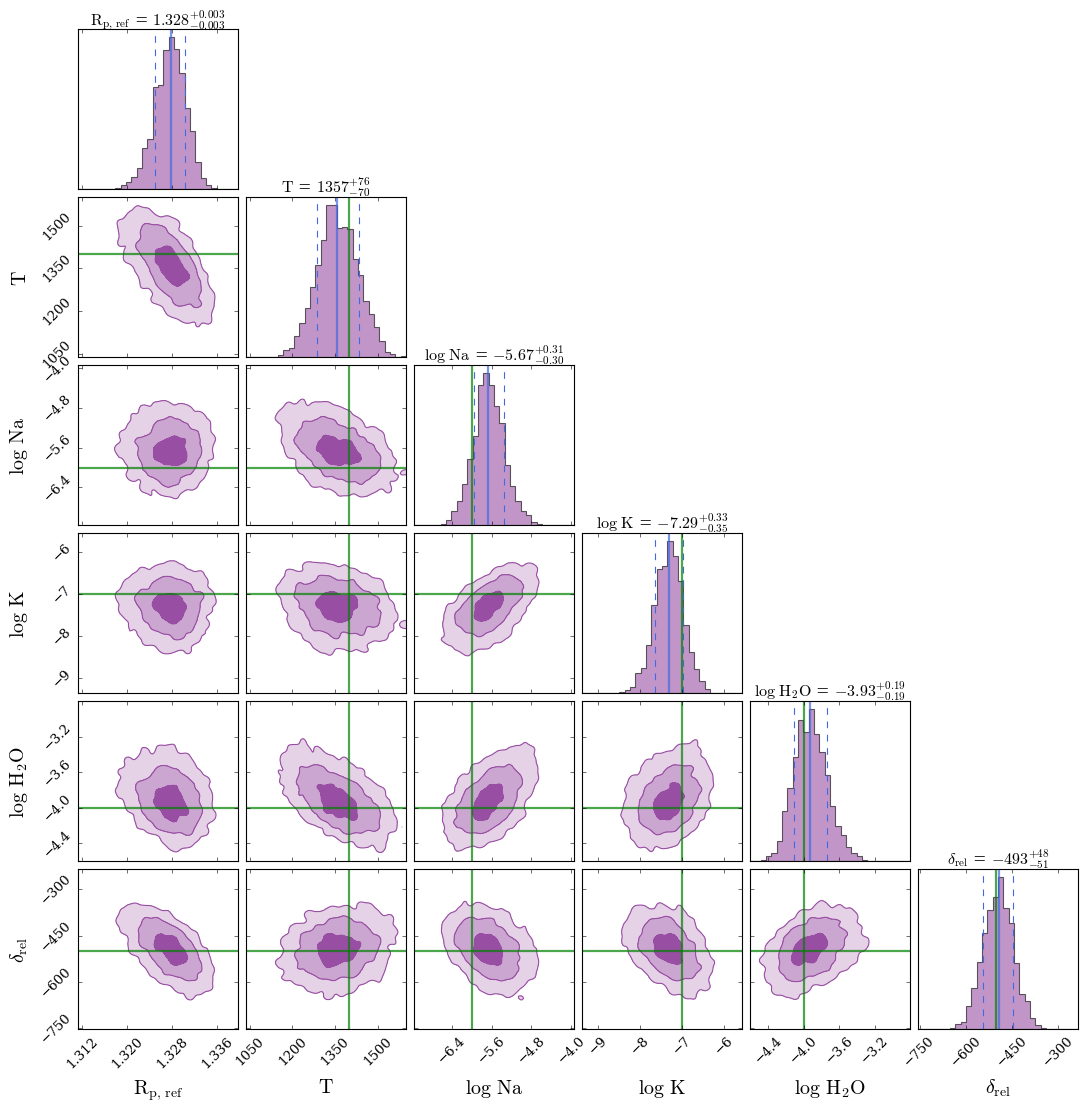

In [15]:
fig_corner = generate_cornerplot(planet, model_offset_stis, 
                                 true_vals = [0.96*(R_p/R_J), 1400, 
                                              -6.0, -7.0, -4.0, -500])   # The last parameter is the offset

The eagle eyed amongst you may notice the retrieved value for the reference radius does not match the 'true' value. This is because we assumed the baseline for the WFC3 G141 data was correct, so by fitting for an offset to the STIS data these data had to increase in transit depth to compensate. Consequently, the overall retrieved planet size had to increase. 

The choice of which dataset has the relative offset applied does not matter for the retrieved atmospheric properties (for symmetry reasons). We can verify this by overplotting the two probability distributions.

Generating corner plot 1...
Generating corner plot 2...


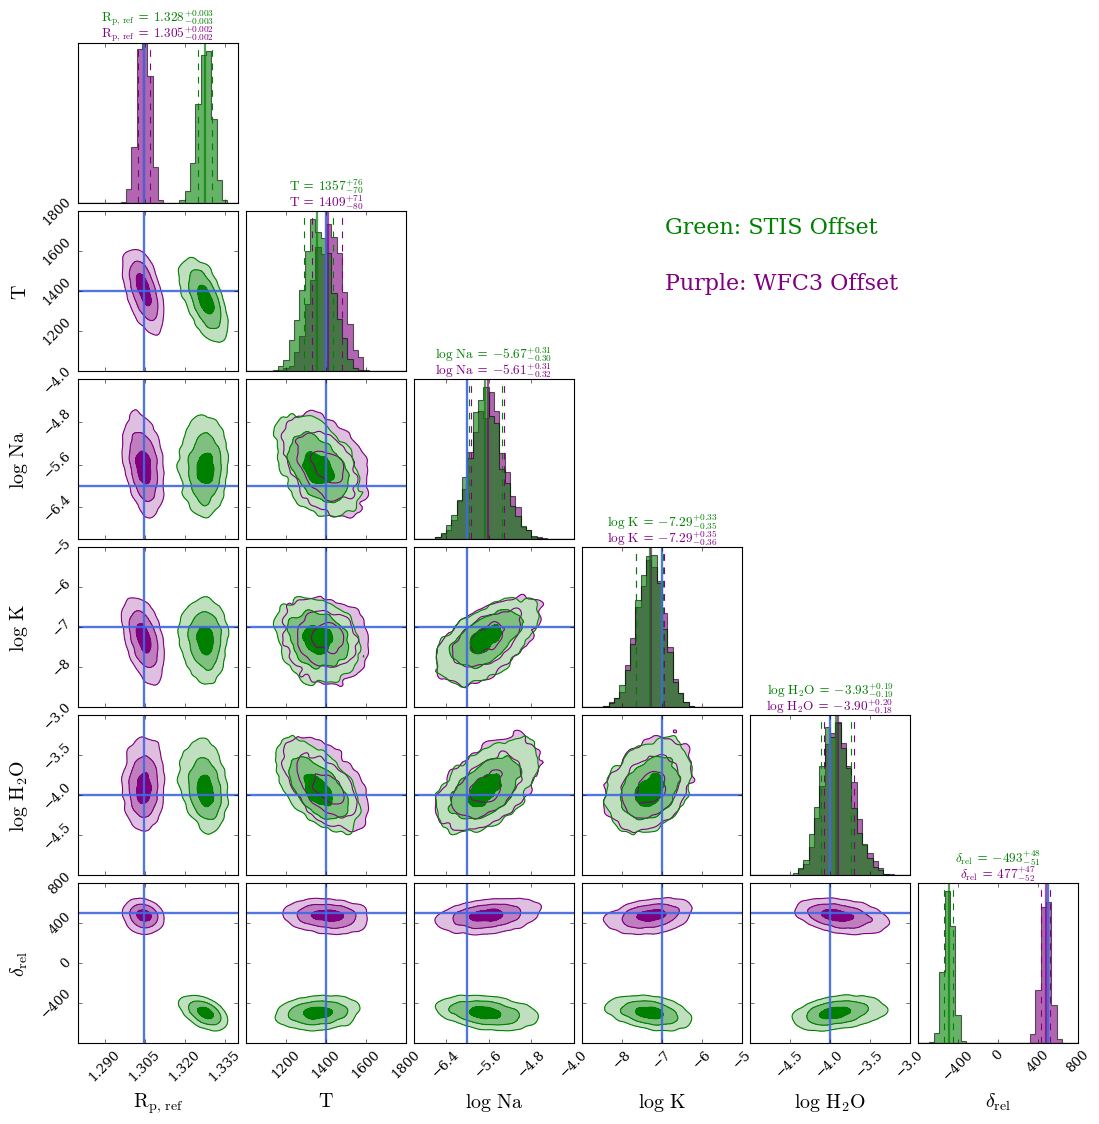

In [16]:
from POSEIDON.corner import generate_overplot

models = [model_offset_wfc3, model_offset_stis]

fig_overplot = generate_overplot(planet, models, 
                                 true_vals = [0.96*(R_p/R_J), 1400, 
                                              -6.0, -7.0, -4.0, 500],
                                 span = [(1.28, 1.34), (1000, 1800), (-7, -4), 
                                         (-9, -5), (-5, -3), (-800, 800)],
                                 colour_schemes = ['purple', 'green'],
                                 truth_colour = 'royalblue',
                                 model_display_names = ['WFC3 Offset', 'STIS Offset'],
                                )

Plotting the retrieved spectra for a grouped offset is the same as above (but notice from the y axis that in this case the STIS data moves up, rather than the WFC3 data moving down).

Applied -493.26 ppm offset to offset_1_datasets


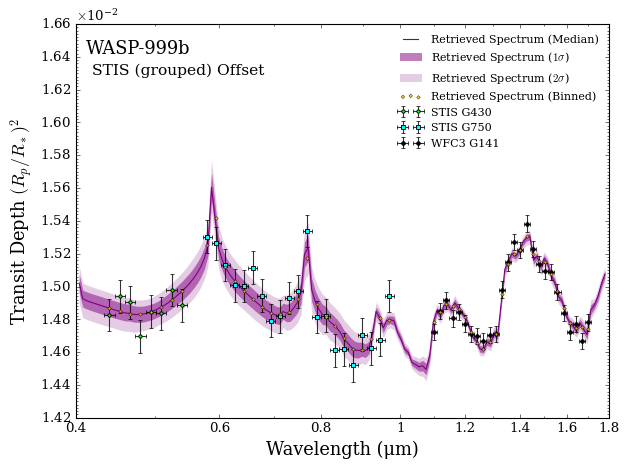

In [17]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved

#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data_offset_stis, R_to_bin = 100,
                                  plt_label = 'STIS (grouped) Offset',
                                  data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141'],
                                  data_colour_list = ['lime', 'cyan', 'black'],
                                  model = model_offset_stis, add_retrieved_offsets = True,
                                  )

## Multiple Free Offsets

Finally, let's see how to fit for multiple retrieved offsets. We'll illustrate this by fitting for one offset on STIS G750 and a second offset on WFC3 G141.

We do this by creating two groups of `offset_i_datasets` (where `i` here is 1 or 2) and setting `offsets_applied` to `two_datasets`.

POSEIDON currently supports up to 3 offset groups.

In [18]:
model_name = 'Retrieval_with_two_offsets'

bulk_species = ['H2', 'He']
param_species = ['Na', 'K', 'H2O']

# Create the model object
model_two_offsets = define_model(model_name, bulk_species, param_species, 
                                 PT_profile = 'isotherm', cloud_model = 'cloud-free',
                                 offsets_applied = 'two_datasets')

# Check the free parameters defining this model
print("Free parameters: " + str(model_two_offsets['param_names']))

Free parameters: ['R_p_ref' 'T' 'log_Na' 'log_K' 'log_H2O' 'delta_rel_1' 'delta_rel_2']


We now see there are two offset parameters, $\delta_{\rm{rel, \, 1}}$ and $\delta_{\rm{rel, \, 2}}$.

Let's indicate which dataset resides in which offset group.

In [19]:
data_two_offsets  = load_data(data_dir, datasets, instruments, wl, 
                              offset_1_datasets = ['WASP-999b_STIS_G750.dat'],
                              offset_2_datasets = ['WASP-999b_WFC3_G141_OFFSET.dat'])

In [20]:
#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_H2O'] = 'uniform'
prior_types['delta_rel_1'] = 'uniform'       # Offset 1
prior_types['delta_rel_2'] = 'uniform'       # Offset 2

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 1600]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_H2O'] = [-12, -1]
prior_ranges['delta_rel_1'] = [-1000, 1000]       # Offset 1
prior_ranges['delta_rel_2'] = [-1000, 1000]       # Offset 2

# Set priors
priors = set_priors(planet, star, model_two_offsets, data_two_offsets, 
                    prior_types, prior_ranges)

#**** Run atmospheric retrieval *****#

run_retrieval(planet, star, model_two_offsets, opac, data_two_offsets, priors, 
              wl, P, P_ref, R = R, spectrum_type = 'transmission', 
              sampling_algorithm = 'MultiNest', N_live = 400, verbose = False)

POSEIDON now running 'Retrieval_with_two_offsets'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************
POSEIDON retrieval finished in 0.24 hours
 ln(ev)=   429.62690768266486      +/-  0.21272714694821276     
 Total Likelihood Evaluations:        36783
 Sampling finished. Exiting MultiNest
Now generating 1000 sampled spectra and P-T profiles from the posterior distribution...
This process will take approximately 0.39 minutes
All done! Output files can be found in ./POSEIDON_output/WASP-999b/retrievals/results/


Since we know that there isn't an offset between the two STIS datasets, we expect the first offset to be consistent with 0 ppm and the second to be close to 500 ppm. Let's confirm that.

Generating corner plot ...


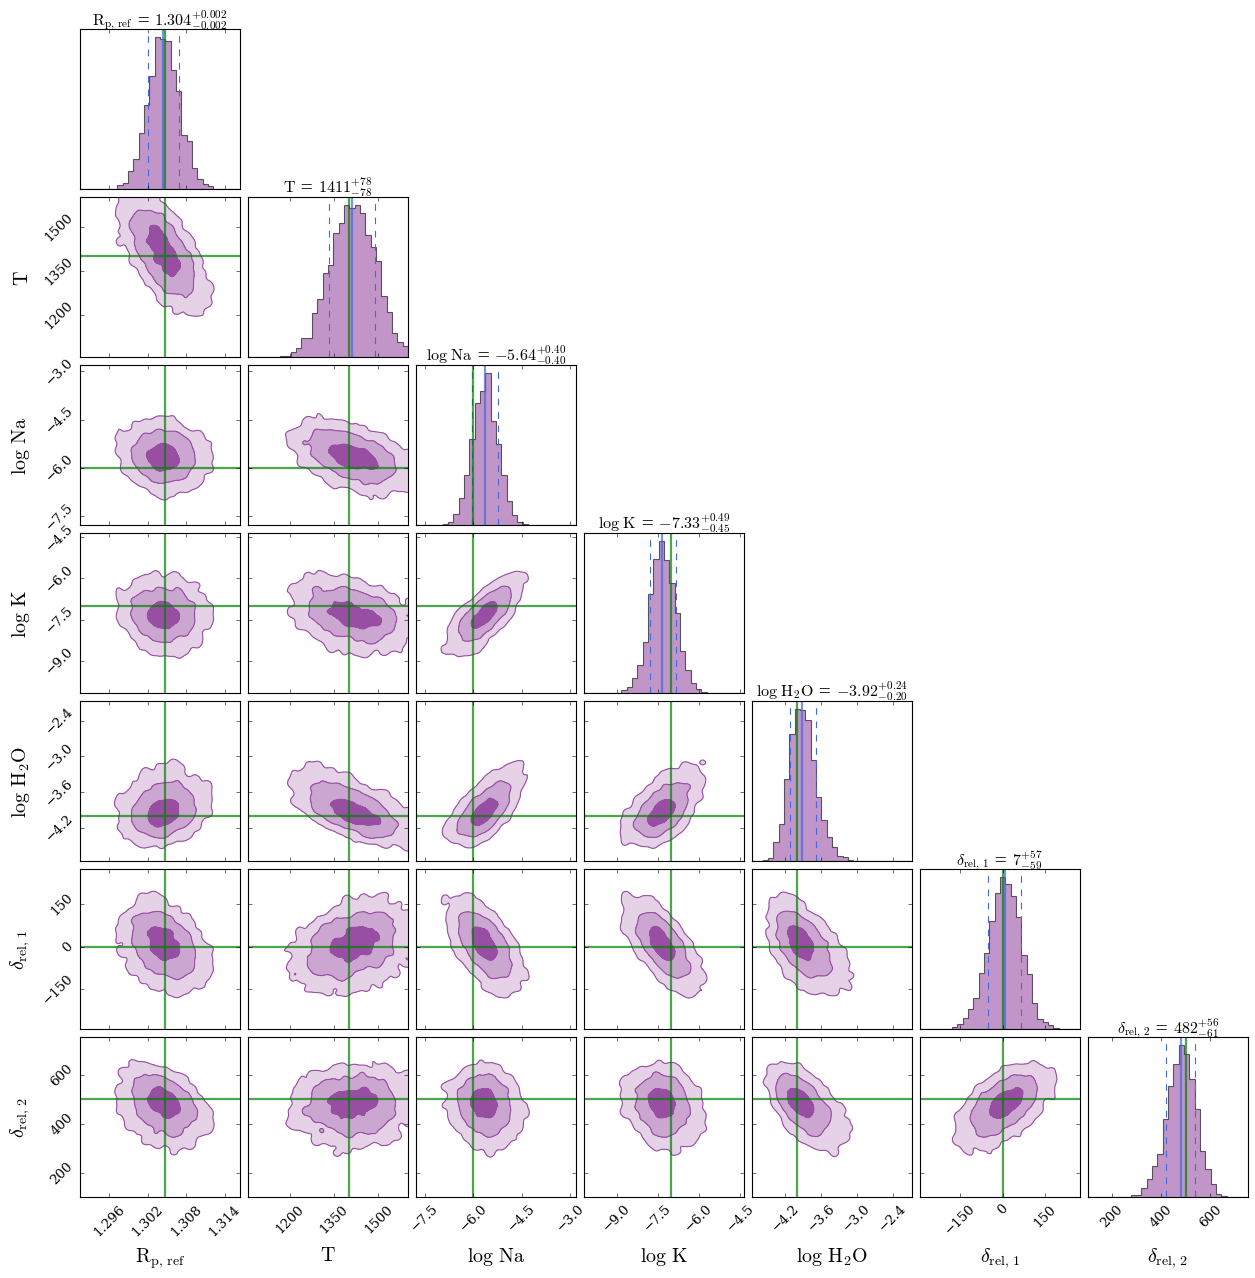

In [21]:
fig_corner = generate_cornerplot(planet, model_two_offsets, 
                                 true_vals = [0.96*(R_p/R_J), 1400, 
                                              -6.0, -7.0, -4.0, 0, 500])   # The last two parameters are the offsets

Hurrah, our intuition actually works! 🎉